In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Configure Environment

In [ ]:
!nvidia-smi

Sat May 18 16:37:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   34C    P8              11W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
!pip -q install transformers datasets
!pip -q install huggingface_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.8/547.8 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.1/316.1 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", w

In [2]:
!git clone https://github.com/huggingface/diffusers
%cd diffusers
%pip install .


Cloning into 'diffusers'...
remote: Enumerating objects: 67076, done.
remote: Counting objects: 100% (1433/1433), done.
remote: Compressing objects: 100% (716/716), done.
remote: Total 67076 (delta 962), reused 973 (delta 607), pack-reused 65643
Receiving objects: 100% (67076/67076), 47.96 MiB | 25.30 MiB/s, done.
Resolving deltas: 100% (49376/49376), done.
/content/diffusers
Processing /content/diffusers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.30.0.dev0-py3-none-any.whl size=2548755 sha256=fe5fa03e4f81a26f62c4cc9bd8d0d1221d13f8bb30442c4345576a2cdfc5d777
  Stored in directory: /tmp/pip-ephem-wheel-cache-z0yk7oeg/wheels/95/c5/3b/e1b4269f8a2584de57e75f949a185b48fc4144e9a91fc9965a
Successfully built diffusers


In [ ]:
%cd examples/text_to_image
%pip -q install -r requirements.txt

/content/diffusers/examples/text_to_image
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 7.8 MB/s eta 0:00:00


In [ ]:
!accelerate config default --mixed_precision fp16

# Import Librraies

In [ ]:
import os
from tqdm.notebook import tqdm
from PIL import Image
import io
from datasets import load_dataset
import matplotlib.pyplot as plt
from huggingface_hub import notebook_login


# Prepare Data

In [ ]:
dataset = load_dataset("master-frog/flooring", split="train")

dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/12000 [00:00<?, ? examples/s]

Dataset({
    features: ['indices', 'plans', 'walls', 'colors', 'footprints', 'plan_captions'],
    num_rows: 12000
})

In [ ]:
from datasets import Dataset, DatasetDict

# Convert the list of dictionaries into a dictionary of lists
data_dict = {'text': [item['plan_captions'] for item in dataset],
             'image': [item['plans'] for item in dataset]}

# Create a Hugging Face Dataset
dataset = Dataset.from_dict(data_dict)
train_data = DatasetDict({'train':dataset})

In [ ]:
train_data

DatasetDict({
    train: Dataset({
        features: ['text', 'image'],
        num_rows: 12000
    })
})

# Display Samples

Sample 1 text: a floor plan drawing, the rooms are used for the living room, kitchen, bedroom and bathroom,the furniture types are the chairs, the table, the sofa, the bed, the wardrobe, the wardrobe, the bed, the wardrobe, the bed, the wardrobe, the bed, the wardrobe, the bed, the wardrobe, the bed, the,
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=512x512 at 0x79567A9B56F0>


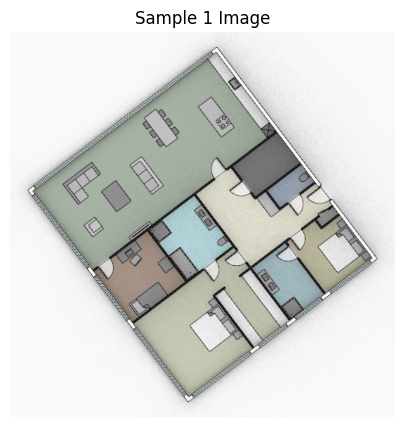

Sample 2 text: a floor plan drawing, the rooms are used for the living room, dining room, kitchen, and bedroom,the furniture types are the chairs, the table, the sofa, the bed, the wardrobe, the wardrobe, the bed, the wardrobe, the bed, the wardrobe, the bed, the wardrobe, the bed, the wardrobe, the bed, the,
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=512x512 at 0x795679523820>


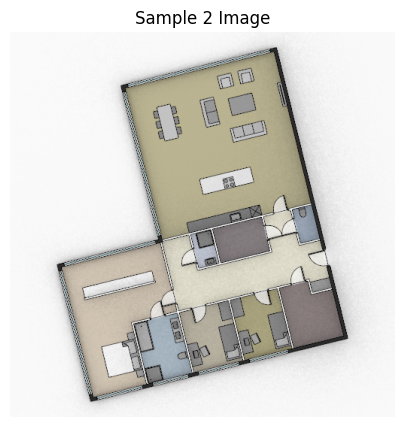

Sample 3 text: a floor plan drawing, the rooms are used for the living room, kitchen, bedroom and bathroom,the furniture types are the kitchen, dining room, living room, bedroom, and bathroom,
<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=512x512 at 0x79567A529C00>


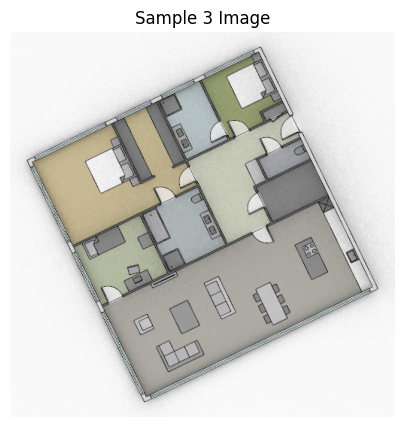

In [ ]:
# Print the text for the first 5 samples
for i in range(3):
    print(f"Sample {i+1} text: {train_data['train'][i]['text']}")

    # The image is already an image object, so we can directly use it
    image = dataset[i]['image']
    print(image)
    plt.figure(figsize=(5,5))
    plt.imshow(image)
    plt.title(f"Sample {i+1} Image")
    plt.axis('off')
    plt.show()

# Push Data tp Huggingface

In [ ]:
# Log in to Hugging Face
notebook_login()


In [ ]:
train_data.push_to_hub("muzammil-eds/house_floor_plans")

Uploading the dataset shards:   0%|          | 0/8 [00:00<?, ?it/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/15 [00:00<?, ?ba/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/15 [00:00<?, ?ba/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/15 [00:00<?, ?ba/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/15 [00:00<?, ?ba/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/15 [00:00<?, ?ba/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/15 [00:00<?, ?ba/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/15 [00:00<?, ?ba/s]

Map:   0%|          | 0/1500 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/15 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/muzammil-eds/house_floor_plans/commit/8c97c02f697c9393d031a24ea340439f39917eb3', commit_message='Upload dataset', commit_description='', oid='8c97c02f697c9393d031a24ea340439f39917eb3', pr_url=None, pr_revision=None, pr_num=None)

# Fine Tuning

In [ ]:
notebook_login()

In [ ]:
# os.environ['MODEL_NAME'] = f'CompVis/stable-diffusion-v1-4'
os.environ['MODEL_NAME'] = f'CompVis/stable-diffusion-v1-4'

os.environ['dataset_name'] = f'muzammil-eds/house_floor_plans'
os.environ['output_dir'] = f'/content/drive/MyDrive/flooring_stable-diffusion-v1.4'

In [ ]:
!accelerate launch  train_text_to_image.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --dataset_name=$dataset_name \
  --use_ema \
  --resolution=512 --center_crop --random_flip \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --gradient_checkpointing \
  --max_train_steps=2000 \
  --learning_rate=1e-05 \
  --max_grad_norm=1 \
  --lr_scheduler="constant" --lr_warmup_steps=0 \
  --output_dir=$output_dir


2024-05-18 14:42:27.306074: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 14:42:27.306129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 14:42:27.308064: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-18 14:42:28.500027: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
05/18/2024 14:42:29 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

scheduler/scheduler_config.json: 100% 313/313 [00:00<00:00, 1.99MB/s]
{'dy

# Predictions

In [ ]:
from diffusers import StableDiffusionPipeline
import torch
from PIL import Image

model_path = '/content/drive/MyDrive/flooring_stable-diffusion-v1.4'
pipe = StableDiffusionPipeline.from_pretrained(model_path, torch_dtype=torch.float16)
pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.28.0.dev0",
  "_name_or_path": "/content/drive/MyDrive/flooring_stable-diffusion-v1.4",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [ ]:
import matplotlib.pyplot as plt


  0%|          | 0/50 [00:00<?, ?it/s]

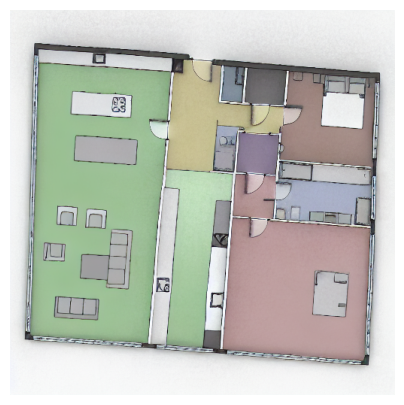

In [ ]:
prompt = "a floor plan drawing, the rooms are used for the living room, kitchen, bedroom and bathroom,the furniture types are the kitchen, dining room, living room, bedroom, and bathroom,"
image = pipe(prompt=prompt).images[0]
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis('off')
plt.show()


  0%|          | 0/50 [00:00<?, ?it/s]

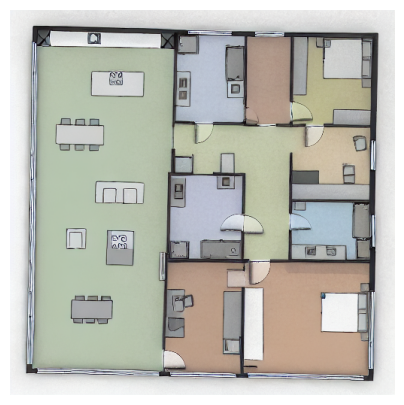

In [ ]:
prompt = "a floor plan drawing, the rooms are used for the living room, kitchen, bedroom and bathroom,the furniture types are the kitchen, dining room, living room, bedroom, and bathroom,"
image = pipe(prompt=prompt).images[0]
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis('off')
plt.show()


  0%|          | 0/50 [00:00<?, ?it/s]

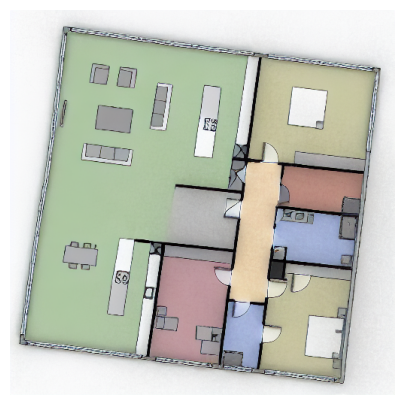

In [ ]:
prompt = "a floor plan drawing, the rooms are used for the rooms,the furniture types are the bed, the sofa, the table, the chair, the wardrobe, the wardrobe, the bed, the sofa, the table, the chair, the wardrobe, the bed, the sofa, the table, the chair, the,"
image = pipe(prompt=prompt).images[0]
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis('off')
plt.show()


  0%|          | 0/50 [00:00<?, ?it/s]

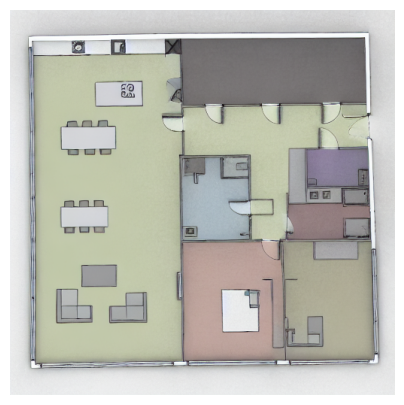

In [ ]:
prompt = "a floor plan drawing, the rooms are used for the living room, kitchen, bedroom and bathroom,the furniture types are the chairs, the table, the sofa, the bed, the wardrobe, the wardrobe, the bed, the wardrobe, the bed, the wardrobe, the bed, the wardrobe, the bed, the wardrobe, the bed, the,"
image = pipe(prompt=prompt).images[0]
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis('off')
plt.show()


  0%|          | 0/50 [00:00<?, ?it/s]

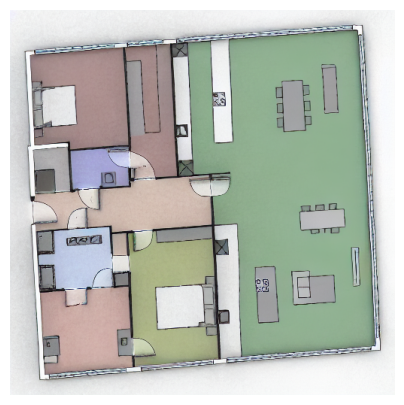

In [ ]:
prompt = "a floor plan drawing, the rooms are used for the living room, kitchen, bedroom and bathroom,,	"
image = pipe(prompt=prompt).images[0]
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.axis('off')
plt.show()
